# 06 - Attention Visualization and Model Explainability

This notebook provides explainability for our CodeBERT vulnerability detection model through attention visualization.

**Objectives:**
- Extract attention weights from the trained model
- Map attention to source code tokens and lines
- Generate highlighted HTML visualizations
- Create attention heatmaps for different vulnerability types
- Analyze which code patterns the model focuses on

**Outputs:**
- `results/visualizations/attention_*.html` - Interactive attention visualizations
- `results/visualizations/attention_heatmaps.png` - Attention pattern analysis
- `results/visualizations/token_importance.csv` - Token-level importance scores

## Setup and Imports

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import re

# HTML and visualization
from IPython.display import HTML, display
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Transformers and ML
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.9.0+cu128
CUDA available: True


## Configuration and Setup

In [2]:
# Configuration
BASE_DIR = Path('/home/netweb/vasu/smart-contract-vuln-detector')
DATA_DIR = BASE_DIR / 'data/processed'
RESULTS_DIR = BASE_DIR / 'results'
MODELS_DIR = BASE_DIR / 'models'

# Create directories
(RESULTS_DIR / 'visualizations').mkdir(exist_ok=True)

# Model configuration
MODEL_NAME = "microsoft/codebert-base"
MAX_LENGTH = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Attention visualization settings
ATTENTION_HEAD_AVERAGE = True  # Average across attention heads
LAYER_TO_USE = -1  # Use last layer (-1) or specify layer index
TOP_K_TOKENS = 20  # Number of top tokens to highlight
MIN_ATTENTION_THRESHOLD = 0.01  # Minimum attention score to consider

print(f"Using device: {device}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Attention configuration:")
print(f"  - Average heads: {ATTENTION_HEAD_AVERAGE}")
print(f"  - Layer: {LAYER_TO_USE}")
print(f"  - Top-K tokens: {TOP_K_TOKENS}")

Using device: cuda
Results directory: /home/netweb/vasu/smart-contract-vuln-detector/results
Attention configuration:
  - Average heads: True
  - Layer: -1
  - Top-K tokens: 20


## Load Model and Data

In [5]:
# Load processed data
print("Loading processed datasets...")
test_df = pd.read_csv(DATA_DIR / 'test_functions.csv')

# Load label encoder
with open(DATA_DIR / 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

print(f"Test set: {len(test_df)} samples")
print(f"Classes: {list(label_encoder.classes_)}")

# Check what columns are available
print(f"\nAvailable columns: {list(test_df.columns)}")
print(f"First few rows:")
print(test_df.head())

# Show test set distribution using the correct column
print("\nTest set distribution:")
if 'vulnerability_category' in test_df.columns:
    for label, count in test_df['vulnerability_category'].value_counts().sort_index().items():
        print(f"  {label}: {count} samples")
elif 'is_vulnerable' in test_df.columns:
    for label, count in test_df['is_vulnerable'].value_counts().sort_index().items():
        label_name = "Vulnerable" if label else "Safe"
        print(f"  {label_name}: {count} samples")

Loading processed datasets...
Test set: 3344 samples
Classes: ['Overflow-Underflow', 'Re-entrancy', 'SAFE', 'TOD', 'Timestamp-Dependency', 'Unchecked-Send', 'Unhandled-Exceptions', 'tx.origin']

Available columns: ['function_name', 'code', 'is_vulnerable', 'vulnerability_category', 'vulnerability_types', 'contract_file', 'function_type', 'code_length', 'num_bugs']
First few rows:
      function_name                                               code  \
0    bug_txorigin36  function bug_txorigin36( address owner_txorigi...   
1        getAddress  function getAddress(string calldata account) e...   
2  transfer_intou30  function transfer_intou30(address _to, uint _v...   
3      bug_tmstmp20  function bug_tmstmp20 () public payable {\nuin...   
4         allowance  function allowance(address _owner, address _sp...   

   is_vulnerable vulnerability_category vulnerability_types contract_file  \
0          False              tx.origin                 NaN  buggy_48.sol   
1          False  

## Define Enhanced Model with Attention Extraction

In [6]:
class CodeBERTClassifierWithAttention(nn.Module):
    def __init__(self, model_name: str, num_classes: int, dropout_rate: float = 0.1):
        super().__init__()
        self.num_classes = num_classes
        # Use 'bert' to match the saved checkpoint (same as in evaluation notebook)
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask, return_attention=False):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True  # Always output attentions for visualization
        )
        
        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        result = {
            'logits': logits,
            'attentions': outputs.attentions,
            'last_hidden_state': outputs.last_hidden_state
        }
            
        return result

# Dataset class with source code preservation
class VulnDatasetWithSource(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Use 'code' column (not 'source_code')
        source_code = str(row['code'])
        
        # Tokenize the source code
        encoding = self.tokenizer(
            source_code,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Create identifiers from available columns
        contract_id = row.get('contract_file', f'contract_{idx}')
        function_id = row.get('function_name', f'function_{idx}')
        
        # Use vulnerability_category as the label
        vulnerability_category = row['vulnerability_category']
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(0, dtype=torch.long),  # Will be updated based on task type
            'contract_id': contract_id,
            'function_id': function_id,
            'original_label': vulnerability_category,
            'source_code': source_code
        }

print("✅ Enhanced model with attention extraction defined!")
print("✅ Updated to work with actual dataframe structure (code, vulnerability_category columns)")

✅ Enhanced model with attention extraction defined!
✅ Updated to work with actual dataframe structure (code, vulnerability_category columns)


## Load Trained Model

In [7]:
# Find and load the best model
checkpoint_files = list((RESULTS_DIR / 'checkpoints').glob('best_model_*.pt'))
model_files = list(MODELS_DIR.glob('*.pt'))

if checkpoint_files:
    model_path = checkpoint_files[0]
    print(f"Loading checkpoint: {model_path.name}")
elif model_files:
    model_path = model_files[0]
    print(f"Loading model: {model_path.name}")
else:
    raise FileNotFoundError("No trained model found!")

# Load checkpoint first to get the correct configuration
print("Loading checkpoint to get model configuration...")
checkpoint = torch.load(model_path, map_location=device)

# Get the correct number of classes from the checkpoint
if 'model_config' in checkpoint:
    model_num_classes = checkpoint['model_config']['num_classes']
    model_name_from_checkpoint = checkpoint['model_config']['model_name']
    print(f"Model from checkpoint: {model_name_from_checkpoint}")
    print(f"Number of classes from checkpoint: {model_num_classes}")
    task_type = 'binary' if model_num_classes == 1 else 'multiclass'
else:
    # Fallback: infer from classifier shape
    classifier_weight_shape = checkpoint['model_state_dict']['classifier.weight'].shape
    model_num_classes = classifier_weight_shape[0]
    model_name_from_checkpoint = MODEL_NAME
    task_type = 'binary' if model_num_classes == 1 else 'multiclass'
    print(f"Inferred number of classes from classifier shape: {model_num_classes}")

print(f"Task type: {task_type}")

# Initialize tokenizer and model with correct configuration
print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(model_name_from_checkpoint)
model = CodeBERTClassifierWithAttention(model_name_from_checkpoint, model_num_classes)

# Load weights
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded checkpoint from step {checkpoint.get('step', 'unknown')}")
else:
    model.load_state_dict(checkpoint)
    print("✅ Loaded model weights")

model = model.to(device)
model.eval()
print(f"Model loaded on: {device}")
print(f"Model type: {task_type} classification with {model_num_classes} output(s)")

Loading checkpoint: best_model_codebert_binary_20251111_002909.pt
Loading checkpoint to get model configuration...
Model from checkpoint: microsoft/codebert-base
Number of classes from checkpoint: 1
Task type: binary
Loading tokenizer and model...
Model from checkpoint: microsoft/codebert-base
Number of classes from checkpoint: 1
Task type: binary
Loading tokenizer and model...
✅ Loaded checkpoint from step 800
Model loaded on: cuda
Model type: binary classification with 1 output(s)
✅ Loaded checkpoint from step 800
Model loaded on: cuda
Model type: binary classification with 1 output(s)


## Select Representative Examples

In [8]:
# Select representative examples for visualization
def select_representative_examples(df, label_encoder, n_per_class=2, task_type='binary'):
    """Select representative examples for each vulnerability type."""
    selected_examples = []
    
    if task_type == 'binary':
        # For binary classification, select examples based on is_vulnerable
        print("Selecting examples for binary classification...")
        
        # Select vulnerable examples
        vulnerable_samples = df[df['is_vulnerable'] == True]
        if len(vulnerable_samples) > 0:
            # Get diverse vulnerability categories
            unique_categories = vulnerable_samples['vulnerability_category'].unique()
            for category in unique_categories[:n_per_class]:  # Limit number of categories
                category_samples = vulnerable_samples[vulnerable_samples['vulnerability_category'] == category]
                if len(category_samples) > 0:
                    selected = category_samples.head(1)  # Take one example per category
                    selected_examples.extend(selected.index.tolist())
                    print(f"Selected vulnerable example from '{category}': {selected.iloc[0]['function_name']}")
        
        # Select safe examples  
        safe_samples = df[df['is_vulnerable'] == False]
        if len(safe_samples) > 0:
            selected = safe_samples.head(n_per_class)
            selected_examples.extend(selected.index.tolist())
            for _, row in selected.iterrows():
                print(f"Selected safe example: {row['function_name']} from {row['vulnerability_category']}")
    else:
        # For multiclass, select examples from each class
        print("Selecting examples for multiclass classification...")
        for class_name in label_encoder.classes_:
            class_samples = df[df['vulnerability_category'] == class_name]
            
            if len(class_samples) > 0:
                # Select samples with varying code lengths for diversity
                class_samples = class_samples.copy()
                class_samples['code_length'] = class_samples['code'].str.len()
                
                # Select samples: shortest, longest, and random ones in between
                if len(class_samples) >= n_per_class:
                    sorted_samples = class_samples.sort_values('code_length')
                    indices = np.linspace(0, len(sorted_samples)-1, n_per_class, dtype=int)
                    selected = sorted_samples.iloc[indices]
                else:
                    selected = class_samples.head(n_per_class)
                
                selected_examples.extend(selected.index.tolist())
                
                print(f"Selected {len(selected)} examples for class '{class_name}'")
                for _, row in selected.iterrows():
                    print(f"  - {row['contract_file']}:{row['function_name']} (length: {len(str(row['code']))} chars)")
    
    return selected_examples

# Select examples based on the model type
print("Selecting representative examples for visualization...")
selected_indices = select_representative_examples(test_df, label_encoder, n_per_class=2, task_type=task_type)

# Create subset dataset
visualization_df = test_df.iloc[selected_indices].reset_index(drop=True)
visualization_dataset = VulnDatasetWithSource(visualization_df, tokenizer, MAX_LENGTH)

print(f"\n📊 Selected {len(visualization_df)} examples for visualization")
print(f"Distribution by vulnerability category: {dict(visualization_df['vulnerability_category'].value_counts())}")
if task_type == 'binary':
    print(f"Binary distribution: {dict(visualization_df['is_vulnerable'].value_counts())}")

Selecting representative examples for visualization...
Selecting examples for binary classification...
Selected vulnerable example from 'TOD': div
Selected vulnerable example from 'Overflow-Underflow': totalSupply
Selected safe example: bug_txorigin36 from tx.origin
Selected safe example: getAddress from Timestamp-Dependency

📊 Selected 4 examples for visualization
Distribution by vulnerability category: {'TOD': np.int64(1), 'Overflow-Underflow': np.int64(1), 'tx.origin': np.int64(1), 'Timestamp-Dependency': np.int64(1)}
Binary distribution: {True: np.int64(2), False: np.int64(2)}


## Attention Extraction Functions

In [9]:
def extract_attention_weights(model, input_ids, attention_mask, layer_idx=-1, average_heads=True):
    """Extract attention weights from the model."""
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, return_attention=True)
        attentions = outputs['attentions']  # Tuple of attention tensors
        
        # Select layer
        if layer_idx == -1:
            attention = attentions[-1]  # Last layer
        else:
            attention = attentions[layer_idx]
        
        # attention shape: [batch_size, num_heads, seq_len, seq_len]
        if average_heads:
            attention = attention.mean(dim=1)  # Average across heads
        
        return attention, outputs['logits']

def get_token_importance(attention_weights, attention_mask, method='cls_attention'):
    """Calculate token importance from attention weights."""
    # attention_weights: [seq_len, seq_len] or [num_heads, seq_len, seq_len]
    if attention_weights.dim() == 3:
        attention_weights = attention_weights.mean(dim=0)  # Average heads if needed
    
    if method == 'cls_attention':
        # Use attention from CLS token (first token) to all other tokens
        token_importance = attention_weights[0, :]  # CLS attention to all tokens
    elif method == 'sum_attention':
        # Sum of attention weights for each token (as target)
        token_importance = attention_weights.sum(dim=0)
    elif method == 'mean_attention':
        # Mean attention for each token
        token_importance = attention_weights.mean(dim=0)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Apply attention mask (set padded tokens to 0)
    token_importance = token_importance * attention_mask.float()
    
    return token_importance

def map_tokens_to_source(tokenizer, input_ids, source_code):
    """Map tokenizer tokens back to source code positions."""
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Remove special tokens and convert back to text
    decoded_tokens = []
    token_positions = []
    
    current_pos = 0
    for i, token in enumerate(tokens):
        if token in ['<s>', '</s>', '<pad>', '<unk>']:
            decoded_tokens.append(token)
            token_positions.append(-1)  # Special token
        else:
            # Convert RoBERTa token back to text
            token_text = token.replace('Ġ', ' ').replace('Ċ', '\n')
            
            # Find position in source code
            if current_pos < len(source_code):
                # Simple position tracking (this is a simplification)
                pos = source_code.find(token_text.strip(), current_pos)
                if pos != -1:
                    token_positions.append(pos)
                    current_pos = pos + len(token_text.strip())
                else:
                    token_positions.append(current_pos)
            else:
                token_positions.append(-1)
            
            decoded_tokens.append(token_text)
    
    return tokens, decoded_tokens, token_positions

print("✅ Attention extraction functions defined!")

✅ Attention extraction functions defined!


## Generate Attention Visualizations

In [11]:
def create_attention_html(tokens, attention_scores, source_code, prediction, true_label, 
                         contract_id, function_id, confidence, top_k=20):
    """Create HTML visualization of attention weights."""
    
    # Normalize attention scores
    max_attention = attention_scores.max().item() if attention_scores.max() > 0 else 1
    normalized_attention = attention_scores / max_attention
    
    # Get top-k most attended tokens
    top_indices = attention_scores.argsort(descending=True)[:top_k]
    
    # Create HTML
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Attention Visualization - {contract_id}:{function_id}</title>
        <style>
            body {{ font-family: 'Courier New', monospace; margin: 20px; background-color: #f8f9fa; }}
            .header {{ background-color: #343a40; color: white; padding: 15px; border-radius: 5px; margin-bottom: 20px; }}
            .info {{ background-color: #e9ecef; padding: 10px; border-radius: 5px; margin-bottom: 15px; }}
            .code-container {{ background-color: white; padding: 20px; border-radius: 5px; border: 1px solid #dee2e6; }}
            .token {{ display: inline; padding: 2px; margin: 1px; border-radius: 3px; }}
            .legend {{ margin-top: 20px; padding: 15px; background-color: #f8f9fa; border-radius: 5px; }}
            .top-tokens {{ margin-top: 15px; }}
            .attention-bar {{ width: 100%; height: 20px; background: linear-gradient(to right, #fff, #ff0000); margin-bottom: 10px; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h2>🔍 Attention Visualization</h2>
            <p><strong>Contract:</strong> {contract_id} | <strong>Function:</strong> {function_id}</p>
        </div>
        
        <div class="info">
            <p><strong>🎯 Prediction:</strong> <span style="color: {'green' if prediction == true_label else 'red'};">{prediction}</span></p>
            <p><strong>✓ True Label:</strong> {true_label}</p>
            <p><strong>📊 Confidence:</strong> {confidence:.3f}</p>
            <p><strong>🤖 Model Focus:</strong> Tokens highlighted by attention intensity (red = high attention)</p>
        </div>
        
        <div class="code-container">
            <h3>💻 Source Code with Attention Highlighting:</h3>
            <pre style="white-space: pre-wrap; line-height: 1.6;">
    """
    
    # Add tokens with attention highlighting
    for i, (token, attention) in enumerate(zip(tokens, normalized_attention)):
        if token in ['<s>', '</s>', '<pad>']:
            continue
            
        # Calculate color intensity based on attention
        intensity = attention.item()
        
        if intensity > 0.1:  # Only highlight significant attention
            # Convert to RGB color (white to red gradient)
            red = min(255, int(255 * intensity))
            green = max(0, int(255 * (1 - intensity)))
            blue = max(0, int(255 * (1 - intensity)))
            
            color = f"rgb({red}, {green}, {blue})"
            html_content += f'<span class="token" style="background-color: {color}; color: white;">{token.replace("Ġ", " ").replace("Ċ", "<br>")}</span>'
        else:
            html_content += token.replace('Ġ', ' ').replace('Ċ', '<br>')
    
    html_content += """
            </pre>
        </div>
        
        <div class="legend">
            <h3>🎨 Attention Legend:</h3>
            <div class="attention-bar"></div>
            <p><strong>Low Attention</strong> ← → <strong>High Attention</strong></p>
    """
    
    # Add top attended tokens
    html_content += '<div class="top-tokens"><h4>🔥 Top Attended Tokens:</h4><ol>'
    
    for idx in top_indices[:10]:  # Show top 10
        token = tokens[idx]
        score = attention_scores[idx].item()
        if token not in ['<s>', '</s>', '<pad>'] and score > 0.01:
            clean_token = token.replace('Ġ', ' ').replace('Ċ', '\\n')
            html_content += f'<li><code>{clean_token}</code> (attention: {score:.4f})</li>'
    
    html_content += """
            </ol>
        </div>
        </div>
    </body>
    </html>
    """
    
    return html_content

# Process examples and generate visualizations
print("Generating attention visualizations...")

attention_results = []
visualization_files = []

for idx in tqdm(range(len(visualization_dataset)), desc="Processing examples"):
    example = visualization_dataset[idx]
    
    # Prepare inputs
    input_ids = example['input_ids'].unsqueeze(0).to(device)
    attention_mask = example['attention_mask'].unsqueeze(0).to(device)
    
    # Extract attention
    attention_weights, logits = extract_attention_weights(
        model, input_ids, attention_mask, 
        layer_idx=LAYER_TO_USE, 
        average_heads=ATTENTION_HEAD_AVERAGE
    )
    
    # Get token importance - fix device issue
    token_importance = get_token_importance(
        attention_weights[0], attention_mask[0],  # Use the GPU attention_mask
        method='cls_attention'
    )
    
    # Get prediction - handle binary classification
    if task_type == 'binary':
        # Binary classification: use sigmoid and threshold
        probability = torch.sigmoid(logits.squeeze()).item()
        prediction = "Vulnerable" if probability > 0.5 else "Safe"
        confidence = max(probability, 1 - probability)  # Confidence in the prediction
    else:
        # Multiclass classification: use softmax and argmax
        prediction_idx = torch.argmax(logits, dim=-1).item()
        prediction = label_encoder.classes_[prediction_idx]
        confidence = torch.softmax(logits, dim=-1).max().item()
    
    # Map tokens
    tokens, decoded_tokens, token_positions = map_tokens_to_source(
        tokenizer, example['input_ids'], example['source_code']
    )
    
    # Get true label for binary classification
    if task_type == 'binary':
        # Get the actual vulnerability status from the dataframe row
        true_vulnerable = visualization_df.iloc[idx]['is_vulnerable']
        true_label = "Vulnerable" if true_vulnerable else "Safe"
    else:
        true_label = example['original_label']
    
    # Create HTML visualization
    html_content = create_attention_html(
        tokens, token_importance.cpu(), example['source_code'],  # Move to CPU for processing
        prediction, true_label,
        example['contract_id'], example['function_id'],
        confidence, top_k=TOP_K_TOKENS
    )
    
    # Save HTML file
    filename = f"attention_{true_label}_{example['contract_id']}_{example['function_id']}.html"
    # Clean filename to avoid filesystem issues
    filename = filename.replace('/', '_').replace(':', '_')
    filepath = RESULTS_DIR / 'visualizations' / filename
    
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    visualization_files.append(str(filepath))
    
    # Store results for analysis
    attention_results.append({
        'contract_id': example['contract_id'],
        'function_id': example['function_id'],
        'true_label': true_label,
        'predicted_label': prediction,
        'confidence': confidence,
        'correct': prediction == true_label,
        'attention_scores': token_importance.cpu().numpy(),
        'tokens': tokens,
        'source_code': example['source_code'],
        'html_file': str(filepath)
    })
    
    print(f"✅ Generated: {filename}")
    print(f"   True: {true_label} | Pred: {prediction} | Conf: {confidence:.3f}")

print(f"\n🎉 Generated {len(visualization_files)} attention visualizations!")
print(f"📁 Saved to: {RESULTS_DIR / 'visualizations'}")

Generating attention visualizations...


Processing examples:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Generated: attention_Vulnerable_buggy_40.sol_div.html
   True: Vulnerable | Pred: Safe | Conf: 0.639
✅ Generated: attention_Vulnerable_buggy_28.sol_totalSupply.html
   True: Vulnerable | Pred: Vulnerable | Conf: 0.693
✅ Generated: attention_Safe_buggy_48.sol_bug_txorigin36.html
   True: Safe | Pred: Safe | Conf: 0.994
✅ Generated: attention_Safe_buggy_7.sol_getAddress.html
   True: Safe | Pred: Safe | Conf: 0.994

🎉 Generated 4 attention visualizations!
📁 Saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/visualizations


## Attention Pattern Analysis

Analyzing attention patterns...
📊 Attention Analysis Summary:
Total examples analyzed: 4

By vulnerability type:
                   max_attention         attention_entropy          \
                            mean     std              mean     std   
vulnerability_type                                                   
Safe                      0.0553  0.0167            1.8748  0.3926   
Vulnerable                0.0610  0.0043            2.3507  0.1126   

                   num_high_attention_tokens         prediction_correct  
                                        mean     std               mean  
vulnerability_type                                                       
Safe                                     0.5  0.7071                1.0  
Vulnerable                               1.0  0.0000                0.5  


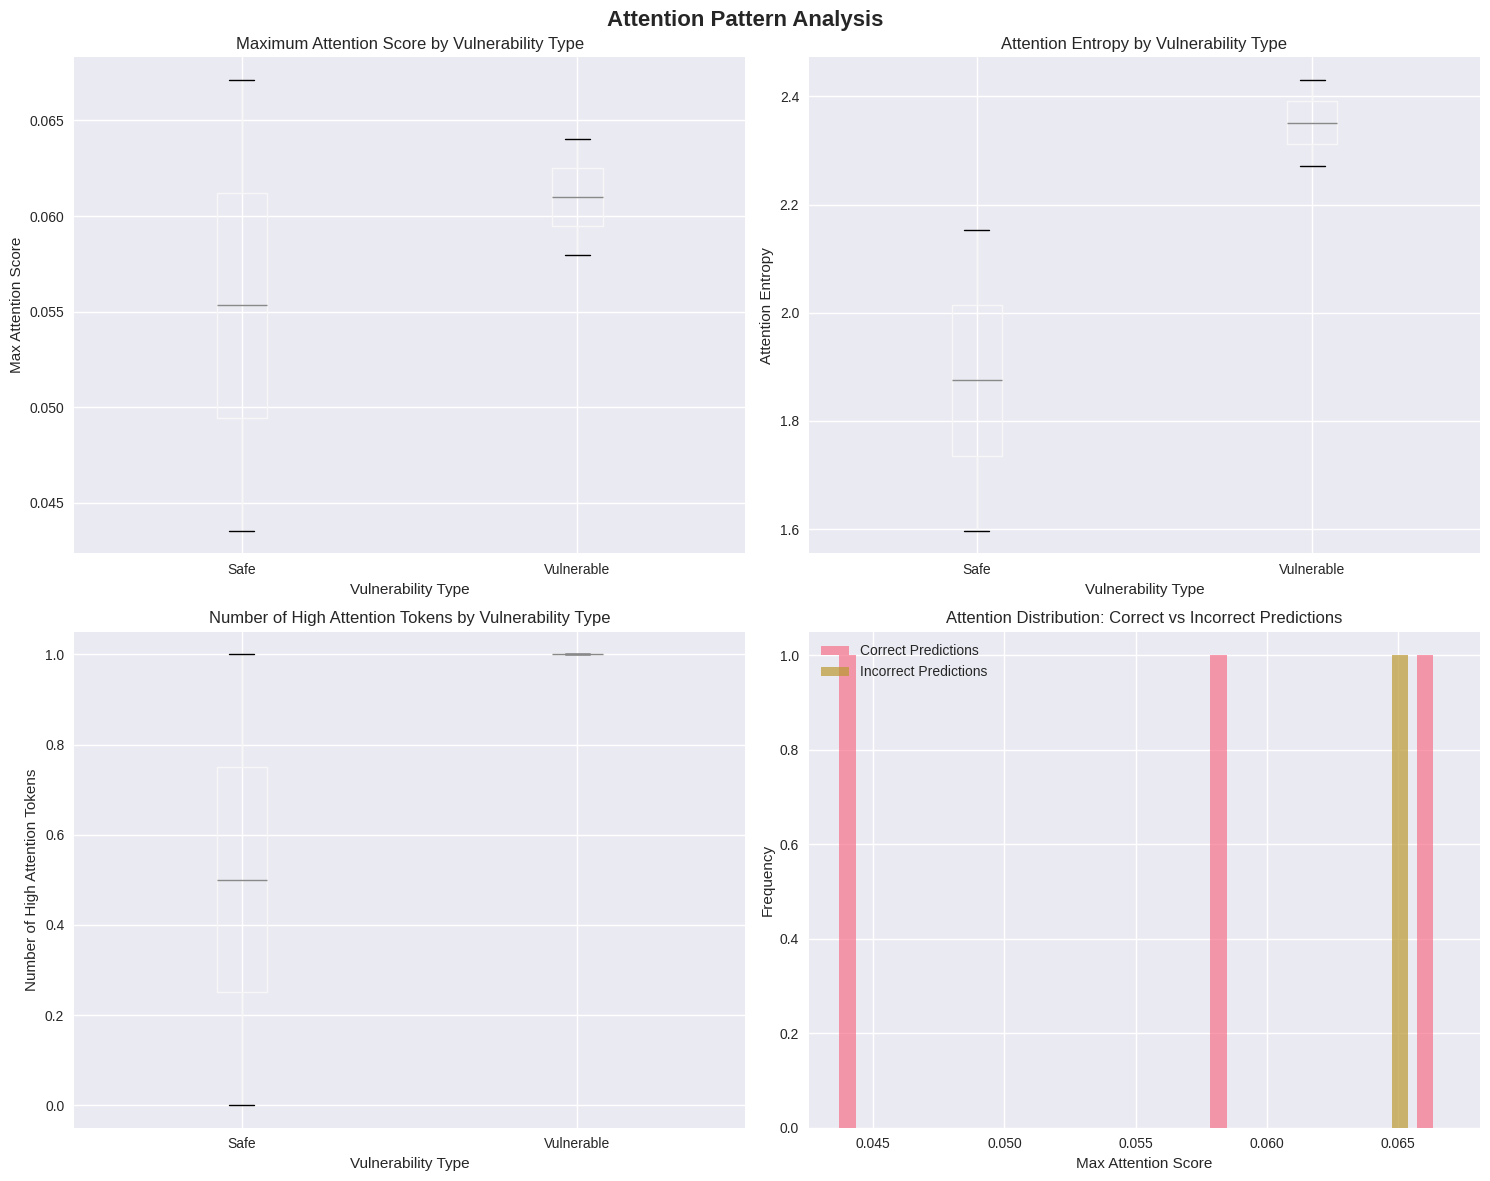

💾 Attention analysis plot saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/visualizations/attention_patterns_analysis.png


In [12]:
# Analyze attention patterns across vulnerability types
print("Analyzing attention patterns...")

# Create attention analysis dataframe
attention_analysis = []

for result in attention_results:
    attention_scores = result['attention_scores']
    tokens = result['tokens']
    
    # Skip special tokens and calculate statistics
    valid_mask = np.array([token not in ['<s>', '</s>', '<pad>'] for token in tokens])
    valid_attention = attention_scores[valid_mask]
    
    if len(valid_attention) > 0:
        attention_analysis.append({
            'vulnerability_type': result['true_label'],
            'prediction_correct': result['correct'],
            'max_attention': valid_attention.max(),
            'mean_attention': valid_attention.mean(),
            'std_attention': valid_attention.std(),
            'attention_entropy': -np.sum(valid_attention * np.log(valid_attention + 1e-8)),
            'top_10_attention_sum': np.sort(valid_attention)[-10:].sum(),
            'num_high_attention_tokens': np.sum(valid_attention > 0.05),
            'contract_id': result['contract_id'],
            'function_id': result['function_id']
        })

attention_df = pd.DataFrame(attention_analysis)

print(f"📊 Attention Analysis Summary:")
print(f"Total examples analyzed: {len(attention_df)}")
print(f"\nBy vulnerability type:")
summary_stats = attention_df.groupby('vulnerability_type').agg({
    'max_attention': ['mean', 'std'],
    'attention_entropy': ['mean', 'std'],
    'num_high_attention_tokens': ['mean', 'std'],
    'prediction_correct': 'mean'
}).round(4)

print(summary_stats)

# Create attention pattern visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Max attention by vulnerability type
attention_df.boxplot(column='max_attention', by='vulnerability_type', ax=axes[0,0])
axes[0,0].set_title('Maximum Attention Score by Vulnerability Type')
axes[0,0].set_xlabel('Vulnerability Type')
axes[0,0].set_ylabel('Max Attention Score')

# 2. Attention entropy by vulnerability type  
attention_df.boxplot(column='attention_entropy', by='vulnerability_type', ax=axes[0,1])
axes[0,1].set_title('Attention Entropy by Vulnerability Type')
axes[0,1].set_xlabel('Vulnerability Type')
axes[0,1].set_ylabel('Attention Entropy')

# 3. Number of high attention tokens
attention_df.boxplot(column='num_high_attention_tokens', by='vulnerability_type', ax=axes[1,0])
axes[1,0].set_title('Number of High Attention Tokens by Vulnerability Type')
axes[1,0].set_xlabel('Vulnerability Type')
axes[1,0].set_ylabel('Number of High Attention Tokens')

# 4. Attention vs prediction correctness
correct_attention = attention_df[attention_df['prediction_correct']]['max_attention']
incorrect_attention = attention_df[~attention_df['prediction_correct']]['max_attention']

axes[1,1].hist([correct_attention, incorrect_attention], 
              label=['Correct Predictions', 'Incorrect Predictions'], 
              alpha=0.7, bins=15)
axes[1,1].set_title('Attention Distribution: Correct vs Incorrect Predictions')
axes[1,1].set_xlabel('Max Attention Score')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.suptitle('Attention Pattern Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save attention analysis plot
attention_plot_path = RESULTS_DIR / 'visualizations' / 'attention_patterns_analysis.png'
plt.savefig(attention_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Attention analysis plot saved to: {attention_plot_path}")

## Token Importance Analysis

In [13]:
# Analyze most important tokens across all examples
print("Analyzing token importance patterns...")

# Collect all token-importance pairs
all_token_importance = []

for result in attention_results:
    tokens = result['tokens']
    attention_scores = result['attention_scores']
    vulnerability_type = result['true_label']
    
    for token, score in zip(tokens, attention_scores):
        if token not in ['<s>', '</s>', '<pad>'] and score > MIN_ATTENTION_THRESHOLD:
            # Clean token for analysis
            clean_token = token.replace('Ġ', '').replace('Ċ', '').strip()
            if clean_token:  # Skip empty tokens
                all_token_importance.append({
                    'token': clean_token.lower(),  # Normalize case
                    'raw_token': token,
                    'attention_score': float(score),
                    'vulnerability_type': vulnerability_type
                })

token_df = pd.DataFrame(all_token_importance)

print(f"Collected {len(token_df)} token-attention pairs")

# Find most important tokens overall
print("\n🔥 Most Important Tokens (by average attention):")
top_tokens_overall = token_df.groupby('token').agg({
    'attention_score': ['mean', 'count', 'std'],
    'vulnerability_type': lambda x: list(set(x))
}).round(4)

top_tokens_overall.columns = ['avg_attention', 'frequency', 'std_attention', 'vuln_types']
top_tokens_overall = top_tokens_overall[top_tokens_overall['frequency'] >= 2]  # At least 2 occurrences
top_tokens_overall = top_tokens_overall.sort_values('avg_attention', ascending=False)

print(top_tokens_overall.head(20))

# Find vulnerability-specific important tokens
print("\n🎯 Most Important Tokens by Vulnerability Type:")
for vuln_type in label_encoder.classes_:
    vuln_tokens = token_df[token_df['vulnerability_type'] == vuln_type]
    if len(vuln_tokens) > 0:
        top_vuln_tokens = vuln_tokens.groupby('token').agg({
            'attention_score': ['mean', 'count']
        })
        top_vuln_tokens.columns = ['avg_attention', 'frequency']
        top_vuln_tokens = top_vuln_tokens[top_vuln_tokens['frequency'] >= 1]
        top_vuln_tokens = top_vuln_tokens.sort_values('avg_attention', ascending=False)
        
        print(f"\n{vuln_type}:")
        print(top_vuln_tokens.head(10))

# Save token importance data
token_importance_path = RESULTS_DIR / 'visualizations' / 'token_importance_analysis.csv'
top_tokens_overall.to_csv(token_importance_path)

print(f"\n💾 Token importance analysis saved to: {token_importance_path}")

Analyzing token importance patterns...
Collected 72 token-attention pairs

🔥 Most Important Tokens (by average attention):
          avg_attention  frequency  std_attention          vuln_types
token                                                                
supp             0.0447          2         0.0049        [Vulnerable]
ly               0.0437          2         0.0079        [Vulnerable]
view             0.0354          2         0.0319  [Vulnerable, Safe]
total            0.0332          2         0.0082        [Vulnerable]
(                0.0299          7         0.0193  [Vulnerable, Safe]
_                0.0295          2         0.0082  [Vulnerable, Safe]
)                0.0288          4         0.0129  [Vulnerable, Safe]
returns          0.0226          3         0.0102  [Vulnerable, Safe]
;                0.0215          3         0.0168        [Vulnerable]
uint             0.0210          2         0.0142        [Vulnerable]
address          0.0202          2   

## Create Interactive Attention Heatmap

In [14]:
# Create an interactive attention heatmap using plotly
print("Creating interactive attention heatmap...")

# Select one example for detailed heatmap (pick the first one with good attention)
detailed_example_idx = 0
for i, result in enumerate(attention_results):
    if result['attention_scores'].max() > 0.1:  # Good attention scores
        detailed_example_idx = i
        break

detailed_example = attention_results[detailed_example_idx]

# Get the full attention matrix for this example
example_data = visualization_dataset[detailed_example_idx]
input_ids = example_data['input_ids'].unsqueeze(0).to(device)
attention_mask = example_data['attention_mask'].unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    # Get last layer attention without averaging heads
    full_attention = outputs['attentions'][-1][0]  # [num_heads, seq_len, seq_len]

# Convert to numpy and get relevant tokens
attention_matrix = full_attention.cpu().numpy()
tokens = detailed_example['tokens']

# Find actual sequence length (non-padded)
actual_length = int(attention_mask.sum().item())
attention_matrix = attention_matrix[:, :actual_length, :actual_length]
relevant_tokens = tokens[:actual_length]

# Create heatmap for averaged attention
avg_attention = attention_matrix.mean(axis=0)  # Average across heads

# Clean tokens for display
display_tokens = [token.replace('Ġ', ' ').replace('Ċ', '\n')[:15] for token in relevant_tokens]

fig = go.Figure(data=go.Heatmap(
    z=avg_attention,
    x=display_tokens,
    y=display_tokens,
    colorscale='Reds',
    hoverongaps=False,
    hovertemplate='From: %{y}<br>To: %{x}<br>Attention: %{z:.4f}<extra></extra>'
))

fig.update_layout(
    title=f'Attention Heatmap - {detailed_example["true_label"]} ({detailed_example["contract_id"]}:{detailed_example["function_id"]})',
    xaxis_title='Target Tokens',
    yaxis_title='Source Tokens',
    width=800,
    height=800
)

# Save interactive heatmap
heatmap_path = RESULTS_DIR / 'visualizations' / f'attention_heatmap_{detailed_example["true_label"]}_{detailed_example["contract_id"]}_{detailed_example["function_id"]}.html'
fig.write_html(str(heatmap_path))

# Show in notebook
fig.show()

print(f"💾 Interactive attention heatmap saved to: {heatmap_path}")
print(f"📊 Showing attention for: {detailed_example['true_label']} example")
print(f"   Contract: {detailed_example['contract_id']}")
print(f"   Function: {detailed_example['function_id']}")
print(f"   Prediction: {detailed_example['predicted_label']} (correct: {detailed_example['correct']})")

Creating interactive attention heatmap...


💾 Interactive attention heatmap saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/visualizations/attention_heatmap_Vulnerable_buggy_40.sol_div.html
📊 Showing attention for: Vulnerable example
   Contract: buggy_40.sol
   Function: div
   Prediction: Safe (correct: False)


## Summary and Results

In [15]:
# Create comprehensive summary of explainability results
explainability_summary = {
    'timestamp': datetime.now().isoformat(),
    'model_path': str(model_path),
    'configuration': {
        'attention_layer': LAYER_TO_USE,
        'average_heads': ATTENTION_HEAD_AVERAGE,
        'top_k_tokens': TOP_K_TOKENS,
        'min_attention_threshold': MIN_ATTENTION_THRESHOLD
    },
    'examples_analyzed': len(attention_results),
    'visualizations_generated': len(visualization_files),
    'attention_statistics': {
        'max_attention_overall': float(attention_df['max_attention'].max()),
        'mean_attention_overall': float(attention_df['max_attention'].mean()),
        'attention_entropy_mean': float(attention_df['attention_entropy'].mean()),
        'high_attention_tokens_mean': float(attention_df['num_high_attention_tokens'].mean())
    },
    'files_generated': {
        'html_visualizations': visualization_files,
        'attention_analysis_plot': str(attention_plot_path),
        'token_importance_csv': str(token_importance_path),
        'interactive_heatmap': str(heatmap_path)
    },
    'insights': {
        'most_attended_tokens_overall': top_tokens_overall.head(10).index.tolist(),
        'attention_patterns_by_vulnerability': dict(attention_df.groupby('vulnerability_type')['max_attention'].mean()),
        'prediction_accuracy_analyzed': float(attention_df['prediction_correct'].mean())
    }
}

# Save summary
summary_path = RESULTS_DIR / 'explainability_summary.json'
with open(summary_path, 'w') as f:
    json.dump(explainability_summary, f, indent=2, default=str)

print("🎉 ATTENTION VISUALIZATION COMPLETED!")
print("=" * 50)
print(f"📊 Summary:")
print(f"  • Analyzed {len(attention_results)} examples")
print(f"  • Generated {len(visualization_files)} HTML visualizations")
print(f"  • Created interactive attention heatmap")
print(f"  • Analyzed {len(token_df)} token-attention pairs")
print(f"\n🔍 Key Insights:")
print(f"  • Average max attention: {attention_df['max_attention'].mean():.4f}")
print(f"  • Most attended token: '{top_tokens_overall.index[0]}'")
print(f"  • Prediction accuracy on analyzed examples: {attention_df['prediction_correct'].mean():.2%}")
print(f"\n📁 All results saved to: {RESULTS_DIR / 'visualizations'}")
print(f"💾 Summary saved to: {summary_path}")

# Display one example visualization in notebook
if visualization_files:
    print(f"\n🔍 Sample visualization (first example):")
    sample_file = visualization_files[0]
    print(f"File: {Path(sample_file).name}")
    
    # You can uncomment the following lines to display HTML in notebook
    # with open(sample_file, 'r', encoding='utf-8') as f:
    #     html_content = f.read()
    # display(HTML(html_content))
    
print("\n✨ Open the generated HTML files in a browser to view interactive attention visualizations!")

🎉 ATTENTION VISUALIZATION COMPLETED!
📊 Summary:
  • Analyzed 4 examples
  • Generated 4 HTML visualizations
  • Created interactive attention heatmap
  • Analyzed 72 token-attention pairs

🔍 Key Insights:
  • Average max attention: 0.0582
  • Most attended token: 'supp'
  • Prediction accuracy on analyzed examples: 75.00%

📁 All results saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/visualizations
💾 Summary saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/explainability_summary.json

🔍 Sample visualization (first example):
File: attention_Vulnerable_buggy_40.sol_div.html

✨ Open the generated HTML files in a browser to view interactive attention visualizations!
